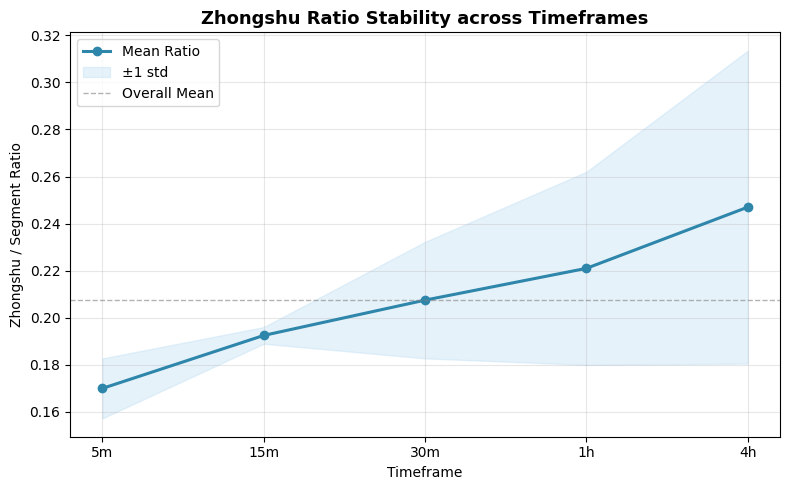

[saved] fig6_1_ratio_stability.png


In [1]:
# ============================================
# Figure 6-1  Zhongshu Ratio Stability
# ============================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve()
TABLES = ROOT / "reports" / "tables"
FIGS = ROOT / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

p_tbl = TABLES / "summary_counts.csv"
df = pd.read_csv(p_tbl)

tf_order = ["5m", "15m", "30m", "1h", "4h"]
ratio_mean = df.groupby("TF")["Zhongshu_Ratio"].mean().reindex(tf_order)
ratio_std = df.groupby("TF")["Zhongshu_Ratio"].std().reindex(tf_order)

plt.figure(figsize=(8,5))
plt.plot(tf_order, ratio_mean, marker="o", lw=2.2, color="#2E86AB", label="Mean Ratio")
plt.fill_between(tf_order,
                 ratio_mean - ratio_std,
                 ratio_mean + ratio_std,
                 color="#AED6F1", alpha=0.3, label="±1 std")

plt.axhline(ratio_mean.mean(), color="gray", ls="--", lw=1, alpha=0.6, label="Overall Mean")
plt.title("Zhongshu Ratio Stability across Timeframes", fontsize=13, weight="bold")
plt.xlabel("Timeframe"); plt.ylabel("Zhongshu / Segment Ratio")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(FIGS / "fig6_1_ratio_stability.png", dpi=300, bbox_inches="tight")
plt.show()

print("[saved] fig6_1_ratio_stability.png")


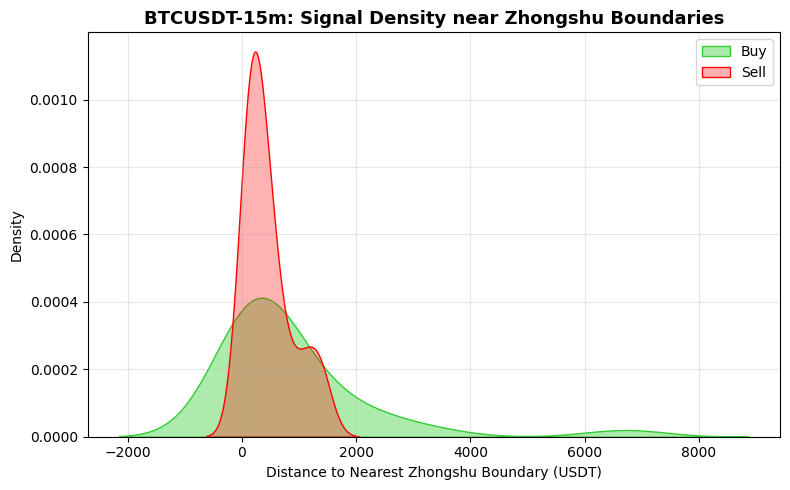

[saved] fig6_2_signal_density.png


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

SYMBOL, TF = "BTCUSDT", "15m"
ROOT = Path.cwd().resolve()
ZS_FAST = ROOT / "chan_data/zhongshu_hierarchy_fast"
SIG = ROOT / "chan_data/signals" / "trading"
FIGS = ROOT / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

p_zs = ZS_FAST / SYMBOL / f"{TF}_L1.csv"
p_sig = SIG / SYMBOL / "multi_tf_trading_signals.csv"
df_zs = pd.read_csv(p_zs)
df_sig = pd.read_csv(p_sig)

for col in ["timestamp_start", "timestamp_end"]:
    df_zs[col] = pd.to_datetime(df_zs[col], errors="coerce").dt.tz_localize(None)
df_sig["ts"] = pd.to_datetime(df_sig["ts"], errors="coerce").dt.tz_localize(None)
df_sig = df_sig[df_sig["tf"] == TF].copy()

distances = []
for _, s in df_sig.iterrows():
    price = s["price"]
    t = s["ts"]
    zs_overlap = df_zs[(df_zs["timestamp_start"] <= t) & (df_zs["timestamp_end"] >= t)]
    if zs_overlap.empty:
        continue
    zs_low = zs_overlap["zs_low"].values
    zs_high = zs_overlap["zs_high"].values
    dmin = np.min(np.abs(price - zs_low))
    dmax = np.min(np.abs(price - zs_high))
    dist_to_zs = min(dmin, dmax)
    distances.append(dict(side=s["side"], dist=dist_to_zs))

dfd = pd.DataFrame(distances)

plt.figure(figsize=(8,5))
sns.kdeplot(data=dfd[dfd["side"]=="buy"], x="dist", fill=True,
            color="limegreen", alpha=0.4, label="Buy")
sns.kdeplot(data=dfd[dfd["side"]=="sell"], x="dist", fill=True,
            color="red", alpha=0.3, label="Sell")
plt.title(f"{SYMBOL}-{TF}: Signal Density near Zhongshu Boundaries", fontsize=13, weight="bold")
plt.xlabel("Distance to Nearest Zhongshu Boundary (USDT)")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(FIGS / "fig6_2_signal_density.png", dpi=300, bbox_inches="tight")
plt.show()

print("[saved] fig6_2_signal_density.png")

/var/folders/5h/q76691gx14l5tvk_8nbdbmg40000gn/T/ipykernel_48032/921902567.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(data, index=dims).replace(score_map)


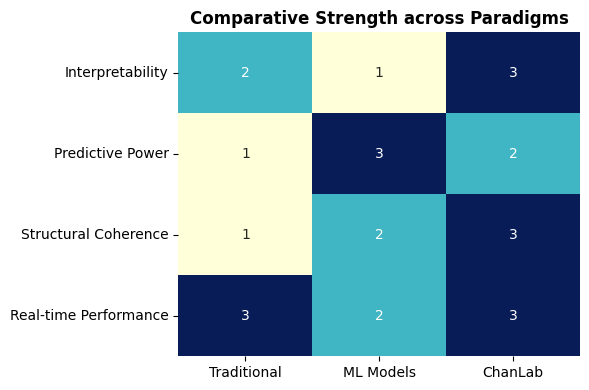

[saved] comparative_heatmap.png


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

ROOT = Path.cwd().resolve()
OUT = ROOT / "reports" / "figures"
OUT.mkdir(parents=True, exist_ok=True)

score_map = {"Low":1, "Medium":2, "High":3}
data = {
    "Traditional": ["Medium","Low","Low","High"],
    "ML Models": ["Low","High","Medium","Medium"],
    "ChanLab": ["High","Medium","High","High"]
}
dims = ["Interpretability","Predictive Power","Structural Coherence","Real-time Performance"]
df = pd.DataFrame(data, index=dims).replace(score_map)

plt.figure(figsize=(6,4))
sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=False, fmt="d")
plt.title("Comparative Strength across Paradigms", fontsize=12, weight="bold")
plt.tight_layout()
plt.savefig(OUT / "comparative_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print("[saved] comparative_heatmap.png")

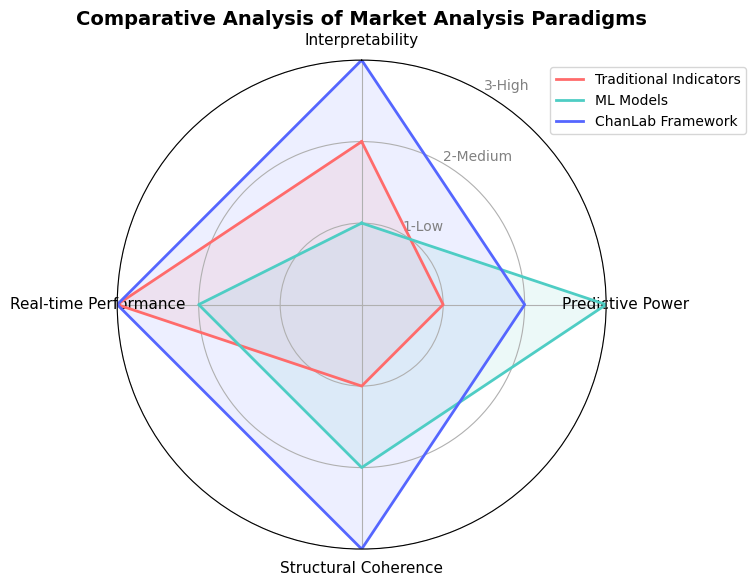

In [6]:
import matplotlib.pyplot as plt
import numpy as np

categories = ["Interpretability", "Predictive Power", "Structural Coherence", "Real-time Performance"]
N = len(categories)

traditional = [2, 1, 1, 3]
ml_models = [1, 3, 2, 2]
chanlab = [3, 2, 3, 3]

angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories, fontsize=11)
ax.set_rlabel_position(30)
plt.yticks([1, 2, 3], ['1-Low', '2-Medium', '3-High'], color="grey", size=10)
plt.ylim(0, 3)

for values, label, color in zip([traditional, ml_models, chanlab],
                               ['Traditional Indicators', 'ML Models', 'ChanLab Framework'],
                               ['#FF6B6B', '#4ECDC4', '#5566FF']):
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

plt.title('Comparative Analysis of Market Analysis Paradigms', size=14, fontweight='bold', ha='center')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.savefig(OUT / "fig6_3_paradigm_radar.png", dpi=300, bbox_inches="tight")
plt.show()